<p style="color:#de3815;font-size:25px;">
Напоминание об оформлении и выполнении ноутбука
</p>

# Generative model of Labels, Abilities, and Difficulties (GLAD)



Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_j, \beta_i-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [134]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [135]:
L = np.load('L.npy')
n, m = L.shape
print(f"Число задач (n_problems): {n}, число экспертов (n_experts): {m}")

Число задач (n_problems): 2000, число экспертов (n_experts): 20


---

Реализуйем EM-алгоритм для заданной выше модели. 

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.


---

In [259]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [260]:
from scipy.special import expit
from scipy.special import softmax
def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    Returns:
        ndarray of shape (2, n_problems)
        (2 -- for z = 0 and for z = 1, n_problems -- for each problem in data)
    Tip:
        You may use function log_likelihood here
        See page 7 of seminar, the last formula for details
    """

    p_0 = log_likelihood(alpha, beta, L, np.zeros(len(beta)))
    p_1 = log_likelihood(alpha, beta, L, np.ones(len(beta)))
    return softmax(np.vstack((p_0, p_1)), axis=0)


def log_likelihood(alpha, beta, L, z):
    """ p(l=z|z, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        z: ndarray of shape (n_problems).
    Returns:
        ndarray of shape (n_problems,)
    Tips:
        See page 7 of seminar, the second formula for details
    """
    m_true = (L.T == z)
    m_false = (L.T != z)
    coef = alpha[:, np.newaxis] @ (beta[np.newaxis, :])
    return np.log(0.5) + ((-softplus(-coef) * m_true) + (-softplus(coef) * m_false)).sum(axis=0)



def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    Returns:
        ndarray of shape (n_experts,)
    Tips:
        See pages 8-9 of seminar for details
    """
    m_true = (L.T == 1)
    m_false = (L.T == 0)
    coef = alpha[:, np.newaxis] @ (beta[np.newaxis, :])
    g_0 = (q[0] * beta * (m_false * expit(-coef) - m_true * expit(coef))).sum(axis=1)
    g_1 = (q[1] * beta * (m_true * expit(-coef) - m_false * expit(coef))).sum(axis=1)
    return g_0 + g_1
    
def logbeta_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    Returns:
        ndarray of shape (n_problems,)
    Tips:
        See pages 8-9 of seminar for details
    """
    m_true = (L.T == 1)
    m_false = (L.T == 0)
    beta[beta < 1e-8] = 1e-8
    coef = alpha[:, np.newaxis] @ (beta[np.newaxis, :])
    g_0 = q[0] * (alpha * ((m_false * expit(-coef) - m_true * expit(coef)) * beta).T).sum(axis=1)
    g_1 = q[1] * (alpha * ((m_true * expit(-coef) - m_false * expit(coef)) * beta).T).sum(axis=1)
    return g_0 + g_1


def lower_bound(alpha, beta, L, q):
    """ Lower bound
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    Returns:
        single value, number
    Tips:
        You may use function log_likelihood here
        See page 8 of seminar, the fourth formula for details
    """
    return np.sum(q[0] * log_likelihood(alpha, beta, L, np.zeros(len(beta))) + q[1] * log_likelihood(alpha, beta, L, np.ones(len(beta))))

In [261]:
from scipy.optimize import check_grad
from scipy.special import expit

alpha, logbeta = np.random.randn(m), np.random.randn(n)
beta = np.exp(logbeta)
q = np.ones((2, len(beta))) * 0.5

check_grad(
    lambda a: lower_bound(a, beta, L, q),
    lambda a: alpha_grad_lb(a, beta, L, q),
    alpha
)

0.0017900599058194087

In [262]:
check_grad(
    lambda lb: lower_bound(alpha, np.exp(lb), L, q),
    lambda lb: logbeta_grad_lb(alpha, np.exp(lb), L, q),
    logbeta
)

0.008809228249178031

In [263]:
def em(L, n_steps=1000, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(beta))) * 0.5

    for step in range(n_steps):
        q = posterior(alpha, np.exp(logbeta), L)
        alpha = alpha + alpha_grad_lb(alpha, np.exp(logbeta), L, q) * lr
        logbeta = logbeta + logbeta_grad_lb(alpha, np.exp(logbeta), L, q) * lr

    return alpha, np.exp(logbeta), q

In [264]:
alpha, beta, q = em(L)

---

Загрузим настоящую разметку. Посчитаем `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством **(?)**, полученным с помощью EM-алгоритма.

---

In [265]:
y = np.load('y.npy')

In [266]:
from sklearn.metrics import accuracy_score

In [267]:
y_vote = (np.sum(L, axis=1) > np.sum(L == 0, axis=1)) * 1
accuracy_score(y, y_vote)

0.904

In [268]:
y_em = np.argmax(q, axis=0)

In [269]:
acc = accuracy_score(y, y_em)
if acc < 0.5:
    acc = 1 - acc
    alpha = -alpha
acc

0.955

---

Попробуем проинтерпретировать полученные коэфициенты $\alpha$.

---

In [270]:
np.sum(alpha < 0)

4

In [271]:
np.sum(alpha >= 4)

4

In [272]:
y_true = np.sum(L.T == y, axis = 1) / L.shape[0]

In [273]:
import matplotlib.pyplot as plt

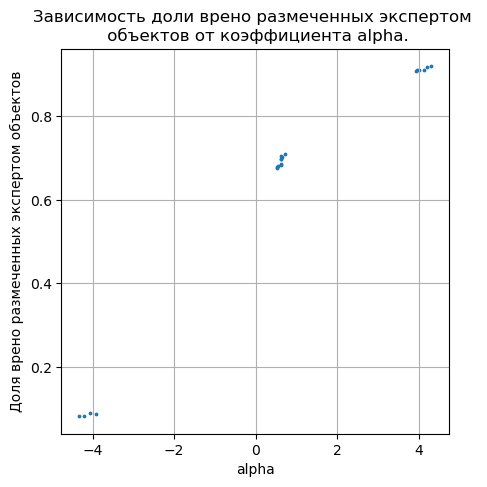

In [274]:
plt.figure(figsize = (5, 5))
plt.title('Зависимость доли врено размеченных экспертом \n объектов от коэффициента alpha.')
plt.scatter(alpha, y_true, s = 3)
plt.xlabel('alpha')
plt.ylabel('Доля врено размеченных экспертом объектов')
plt.grid(True)

В выборке есть эксперты, которые намеренно голосуют неверно. Это можно понять по знаку альфа. В нашей выборке 4 таких эксперта. Как видно из графика есть три группы экспертов: 

* "Вредние" эксперты (4 штуки), у которых alpha < -4 и которые намеренно голосуют неверно. В 90% случаях они дают неверный ответ.
* "Хорошие" эксперты (6 штук), у которых alpha > 4. Они в 90% случаях дают верный ответ. 
* "Глупые") эксперты (10 штук), у котрых alpha > 0, но близок к нулю. Они не уверены в своих ответах и поэтому дают правильный только в 70% случаях.

---

---

# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).


In [20]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


Реализуем функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. 

In [21]:
import glob
from preprocessing import extract_sentences

all_sentences = []
all_targets = []

for file in glob.glob('data/*/*/*.wa'):
    s, t = extract_sentences(file)
    all_sentences.extend(s)
    all_targets.extend(t)

---

 Реализуем функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, построем словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. 

In [22]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [23]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

---

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

Реализуем функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода.

---

In [24]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8115275584918071

---

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

Выведем шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия. 

файл em.pdf

---

Реализуйте класс `WordAligner` в соответствии с полученными вами формулами. 

In [25]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences);
a = word_aligner.align(tokenized_sentences)
compute_aer(all_targets, a)

0.5804008862710558

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [26]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [27]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['Pan', 'řekl', 'pan']

In [28]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [29]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [30]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['konec', 'koni', 'jež']

In [31]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['.', 'se', 'na']

---

 Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный?

---

Используя формулу Байеса:
$$ p(x|y) = \frac{p(y|x) * p(x)}{p(y)} = \frac{p(y|x) * p(x)}{ \sum_z p(y|z) * p(z)} $$ 

$ p(x)$ - частота встречаемости x в корпусе



In [252]:
d = {}
count = 0
for obj in tokenized_sentences:
    for s in obj.source_tokens:
        if s in d:
            d[s] += 1
        else:
            d[s] = 1
        count += 1

In [254]:
translation_probs_evn = word_aligner.translation_probs.copy()
for i in d.keys():
    translation_probs_evn[i, :] *= d[i] / count

translation_probs_evn /= translation_probs_evn.sum(axis=0)

In [50]:
idx_token_src = {index:token for token, index in t_idx_src.items()}

In [255]:
[idx_token_src[i] for i in translation_probs_env.T[t_idx_tgt['pan']].argsort()[-3:]]

['organist', 'choirmaster', 'Mr']

In [256]:
[idx_token_src[i] for i in translation_probs_env.T[t_idx_tgt['musí']].argsort()[-3:]]

['dispute', 'normal', 'must']

In [257]:
[idx_token_src[i] for i in translation_probs_env.T[t_idx_tgt['4']].argsort()[-3:]]

['pounds', 'quits', '4']

In [258]:
[idx_token_src[i] for i in translation_probs_env.T[t_idx_tgt['konec']].argsort()[-3:]]

['depended', 'haggling', 'disorganized']

---

 Визуализируем полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Проинтерпретируйте их.

Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. 

---

In [112]:
import seaborn as sns

In [113]:
l = []
for i in range(len(tokenized_sentences)):
    if len(tokenized_sentences[i].source_tokens) > 50:
        l.append(i)
    if len(l) > 3:
        break

In [128]:
n = len(tokenized_sentences[l[0]].source_tokens)
m = len(tokenized_sentences[l[0]].target_tokens)

In [129]:
data = np.zeros((m, n))
for i, j in a[l[0]]:
    data[j-1, i-1] = 1

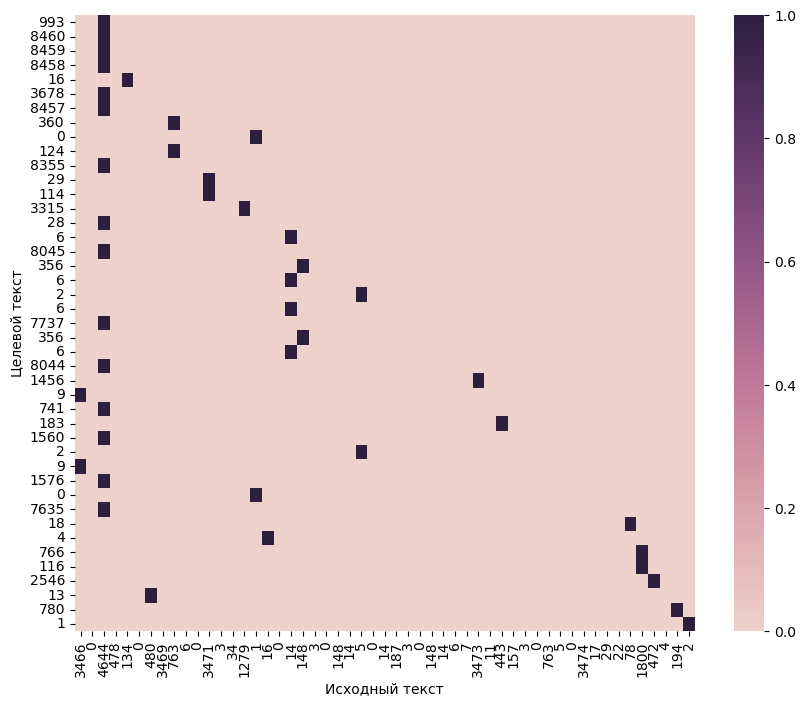

In [130]:
plt.figure(figsize=(10, 8))
sns.heatmap(data, xticklabels=tokenized_sentences[l[0]].source_tokens, 
            yticklabels=tokenized_sentences[l[0]].target_tokens, cmap=sns.cubehelix_palette(as_cmap=True));
plt.xlabel('Исходный текст');
plt.ylabel('Целевой текст');
plt.show()

In [119]:
n = len(tokenized_sentences[l[1]].source_tokens)
m = len(tokenized_sentences[l[1]].target_tokens)
data = np.zeros((m, n))
for i, j in a[l[1]]:
    data[j-1, i-1] = 1

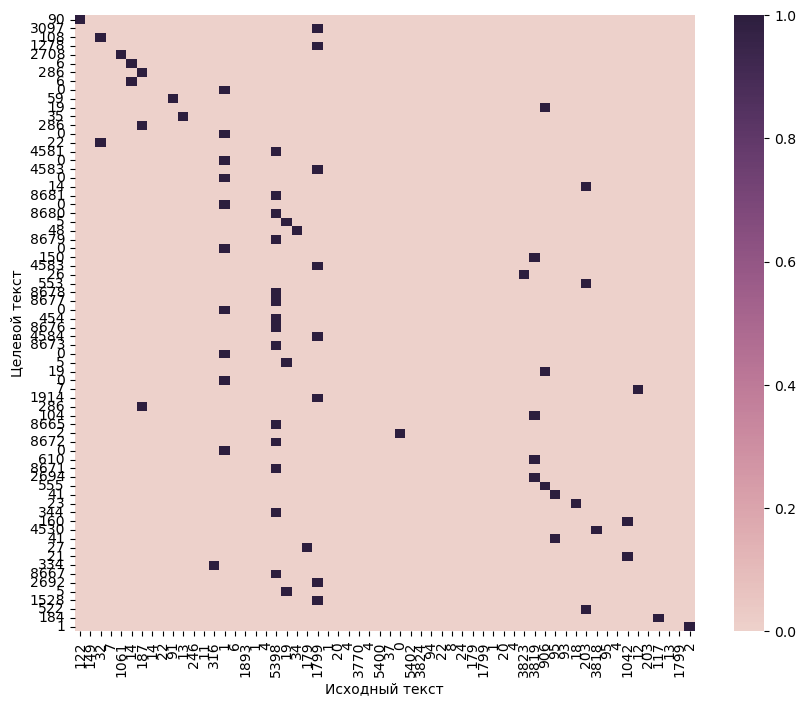

In [127]:
plt.figure(figsize=(10, 8))
sns.heatmap(data, xticklabels=tokenized_sentences[l[1]].source_tokens, 
            yticklabels=tokenized_sentences[l[1]].target_tokens, cmap=sns.cubehelix_palette(as_cmap=True))
plt.xlabel('Исходный текст')
plt.ylabel('Целевой текст')
plt.show()

In [121]:
q = word_aligner._e_step(tokenized_sentences)

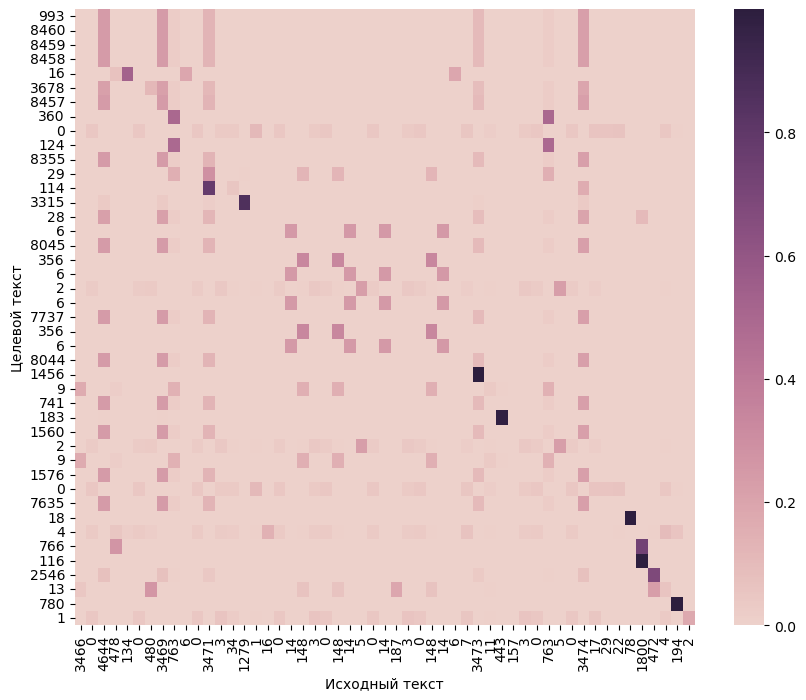

In [131]:
plt.figure(figsize=(10, 8))
sns.heatmap(q[l[0]].T, xticklabels=tokenized_sentences[l[0]].source_tokens, 
            yticklabels=tokenized_sentences[l[0]].target_tokens, cmap=sns.cubehelix_palette(as_cmap=True))
plt.xlabel('Исходный текст')
plt.ylabel('Целевой текст')
plt.show()

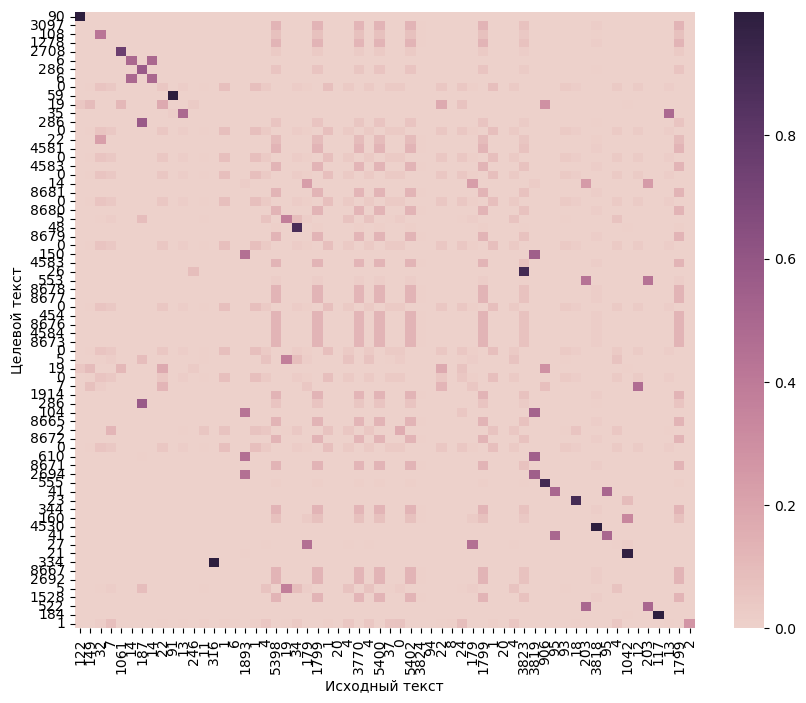

In [133]:
plt.figure(figsize=(10, 8))
sns.heatmap(q[l[1]].T, xticklabels=tokenized_sentences[l[1]].source_tokens, 
            yticklabels=tokenized_sentences[l[1]].target_tokens, cmap=sns.cubehelix_palette(as_cmap=True))
plt.xlabel('Исходный текст')
plt.ylabel('Целевой текст')
plt.show()

Из графиков видно, что вероятности перевода многих слов на другой язык похожи, т.е. модель не уверена в своих ответах.